In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn import preprocessing
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
raw_data = fetch_california_housing()
data = raw_data.data 

In [3]:
lower_percent = np.percentile(data, 1, axis=0)
higher_percent = np.percentile(data, 99, axis=0)

result = np.array([True for i in range(data.shape[0])])
for i in range(len(raw_data.feature_names)):
    lower = data[:,i] >= lower_percent[i]
    higher = data[:,i] <= higher_percent[i]
    result = np.logical_and(result, np.logical_and(lower, higher))
    
data = data[result]

In [4]:
data

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [5]:
data.shape

(18310, 8)

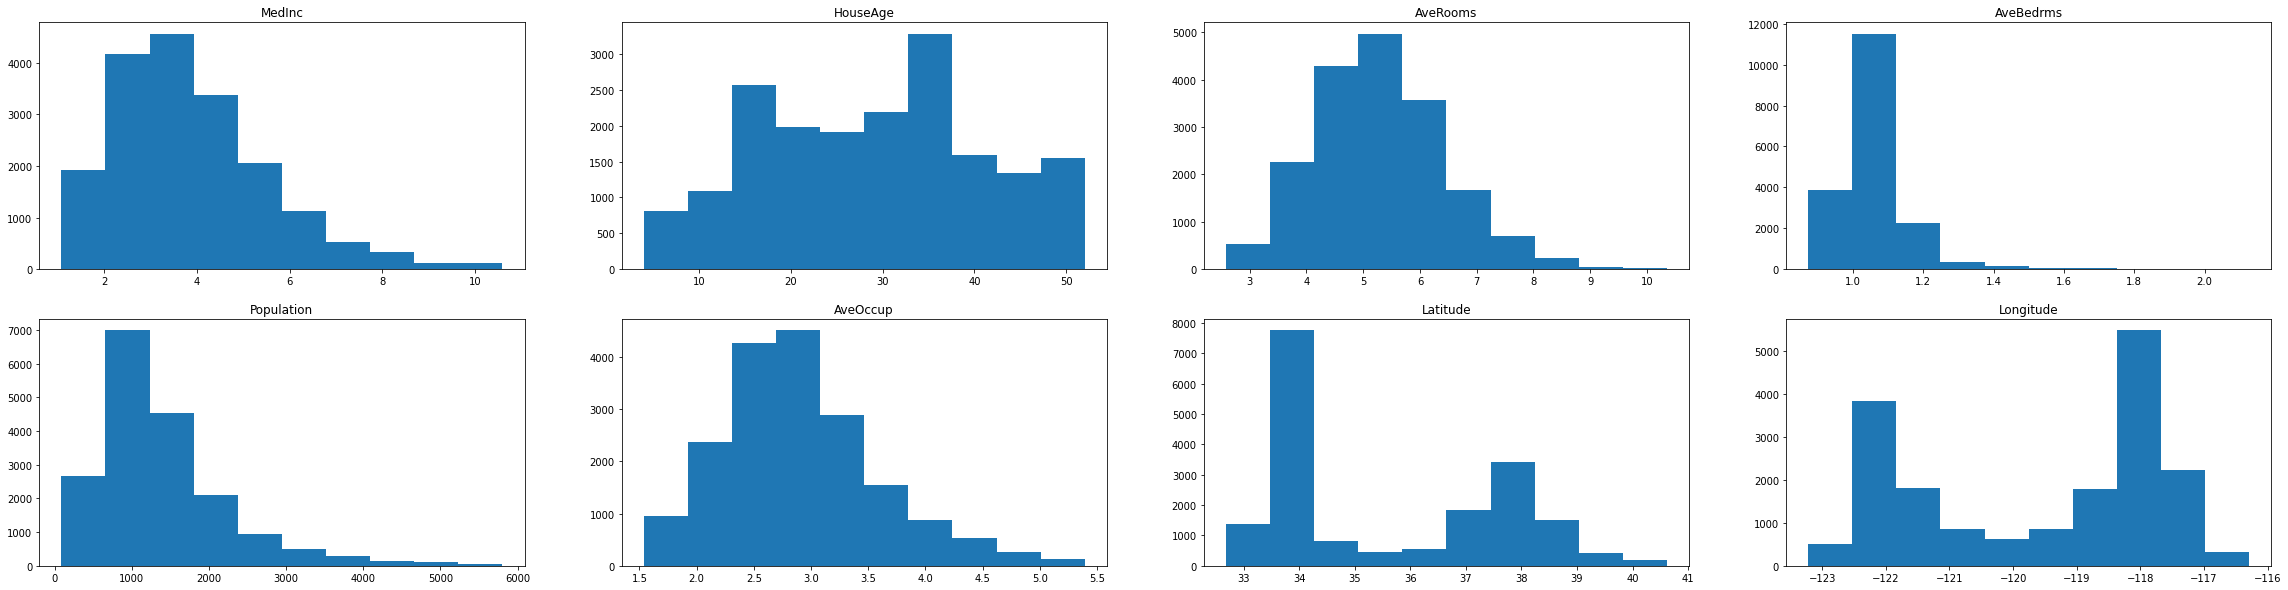

In [6]:
figs, axs = plt.subplots(2, 4, figsize=(40, 10))

for i in range(2):
    for j in range(4): 
        axs[i, j].hist(data[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
plt.show()

In [7]:
# Preprocessing 
print(data.shape)
np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10 

X_train = data[:trainset_size, :]
X_test = data[trainset_size:, :]
print(X_train.shape)
print(X_test.shape)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

(18310, 8)
(12817, 8)
(5493, 8)


In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.bn(self.hidden(out)))
#         out = F.relu(self.hidden2(out))
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)
        
        return mu_z, std_z 

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)
        
        return mu_x, std_x

In [9]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 11
LATENT_DIM = 10
BATCH_SIZE = 128
N_EPOCHS = 2000
lr = 1e-5

In [10]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [11]:
avg_mu_x = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + torch.exp(std_z) * eps
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x

avg_mu_x /= 100
avg_mu_x.shape

avg_mu_x = avg_mu_x.detach().numpy()

In [12]:
avg_mu_x

array([[-0.23267294, -0.1667888 ,  0.32493275, ..., -0.11911168,
         0.2333735 , -0.06130692],
       [-0.22997005, -0.18736817,  0.309298  , ..., -0.12182114,
         0.25025284, -0.05933569],
       [-0.18009233, -0.18297316,  0.29023588, ..., -0.07700933,
         0.26783365, -0.06483194],
       ...,
       [-0.20963709, -0.19552018,  0.28750885, ..., -0.09977455,
         0.27405286, -0.03935967],
       [-0.23661451, -0.17290716,  0.35025546, ..., -0.11628269,
         0.2206696 , -0.08566751],
       [-0.23764057, -0.19942808,  0.3299271 , ..., -0.11222254,
         0.26810282, -0.07415183]], dtype=float32)

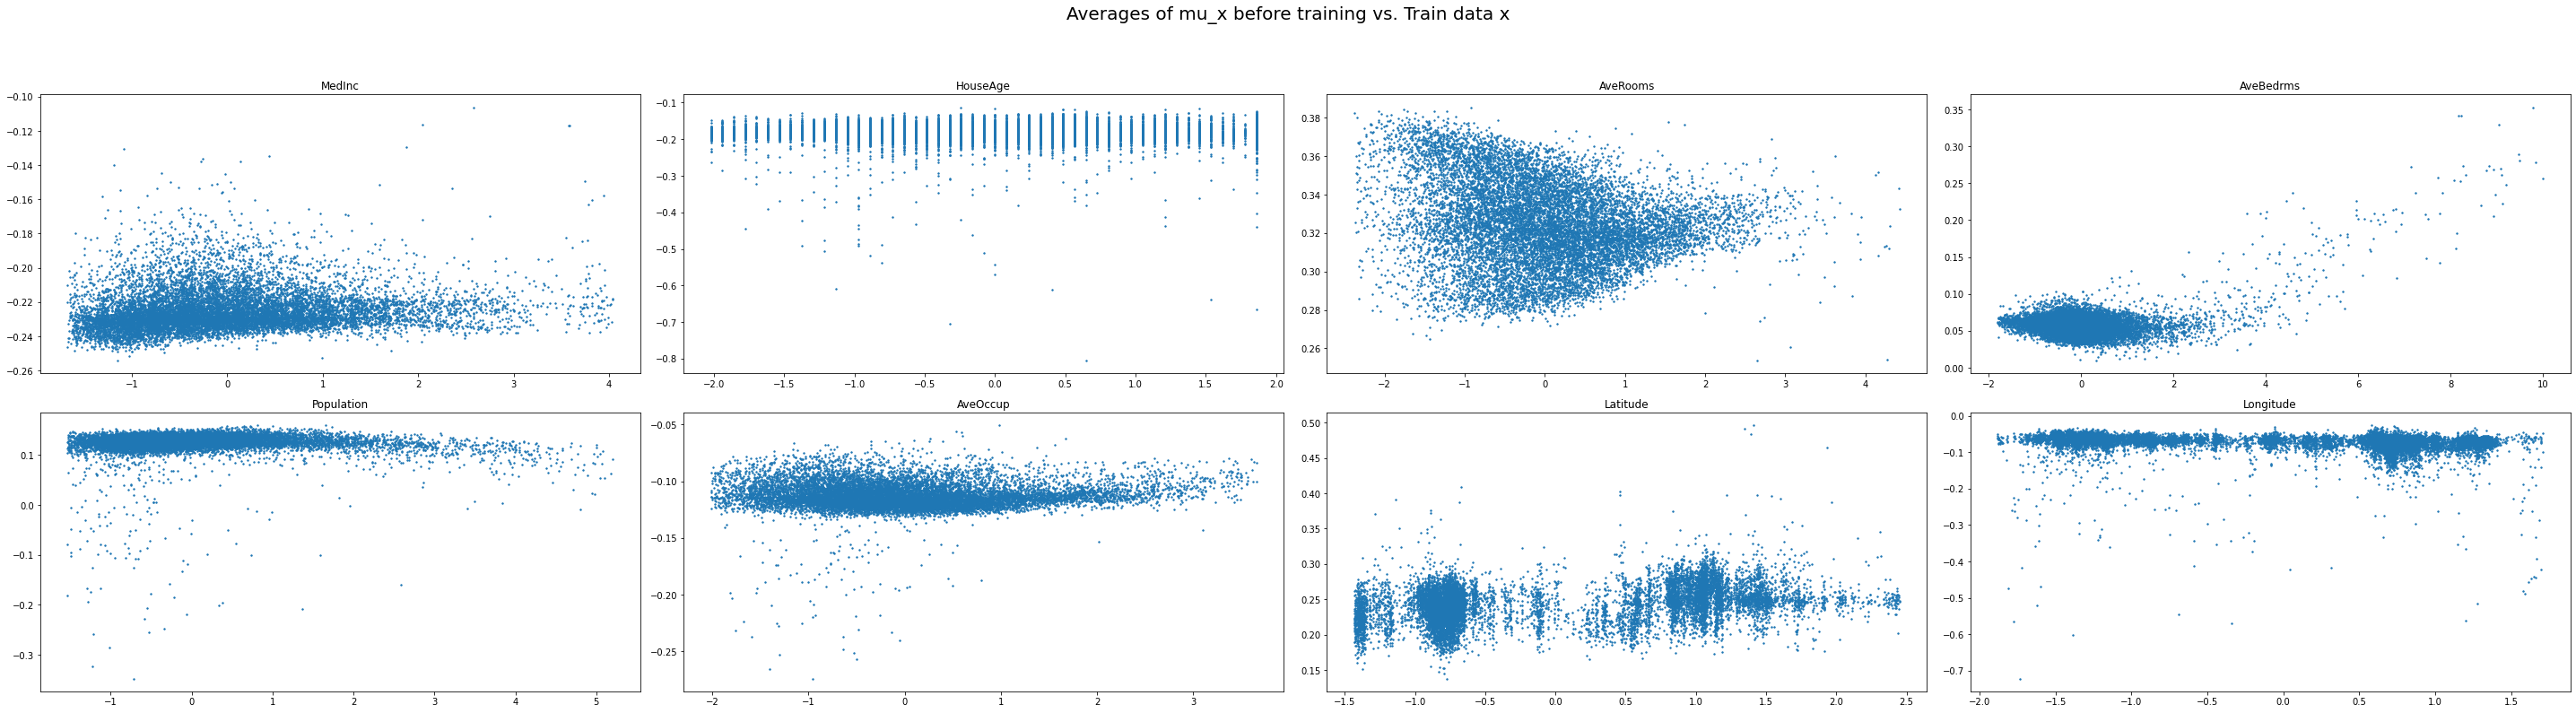

In [13]:
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
for i in range(2): 
    for j in range(4): 
        axs[i, j].scatter(X_train[:, i*4+j], avg_mu_x[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])

figs.tight_layout()
plt.suptitle("Averages of mu_x before training vs. Train data x", fontsize=20, y=1.1)
plt.show()

In [14]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x):
    S = x.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z)
#         torch.sum(log_p_x) - torch.sum(log_p_z)
    )
    
    return loss

In [15]:
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [16]:
train_iter = DataLoader(X_train, batch_size=BATCH_SIZE)
test_iter = DataLoader(X_test, batch_size=BATCH_SIZE)

In [ ]:
train_loss_avg = []
test_loss_avg = []

for i in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x in train_iter: 
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward pass 
        mu_z, std_z = enc(x)
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)
        mu_x, std_x = dec(z_samples)
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward
        loss.backward()
        
        # Update 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
#     scheduler.step()
    train_loss_avg[-1] /= num_batches

    
    with torch.no_grad():
        test_loss_avg.append(0)
        num_batches = 0
        for x_test in test_iter:
            # test
            mu_z_test, std_z_test = enc(x_test)
            eps_test = torch.randn_like(std_z_test)
            z_samples_test = mu_z_test + eps_test * torch.exp(std_z_test)

            mu_x_test, std_x_test = dec(z_samples_test)

            # loss 
            test_loss = loss_fn(mu_z_test, std_z_test, z_samples_test, mu_x_test, std_x_test, x_test)
            test_loss_avg[-1] += test_loss.item()
            num_batches += 1
        test_loss_avg[-1] /= num_batches
    
    if i > 50: 
        prev_mean = sum(train_loss_avg[i-50:i])/50
        curr_mean = sum(train_loss_avg[i-49:i+1])/50
        if 0 <= ((prev_mean - curr_mean) / prev_mean) <= 0.00001:
            print("CONVERGED!!!!")
            break 
    
    print("Epoch [%d / %d] train loss: %f, test loss: %f" % (i+1, N_EPOCHS, train_loss_avg[-1], test_loss_avg[-1]))

Epoch [1 / 2000] train loss: 15.854457, test loss: 15.731684
Epoch [2 / 2000] train loss: 15.649702, test loss: 15.698626
Epoch [3 / 2000] train loss: 15.578622, test loss: 15.517575
Epoch [4 / 2000] train loss: 15.393892, test loss: 15.462113
Epoch [5 / 2000] train loss: 15.391409, test loss: 15.552311
Epoch [6 / 2000] train loss: 15.327258, test loss: 15.320051
Epoch [7 / 2000] train loss: 15.277985, test loss: 15.123522
Epoch [8 / 2000] train loss: 14.996593, test loss: 15.058257
Epoch [9 / 2000] train loss: 14.971080, test loss: 15.211014
Epoch [10 / 2000] train loss: 14.894963, test loss: 14.872202
Epoch [11 / 2000] train loss: 14.728354, test loss: 14.815385
Epoch [12 / 2000] train loss: 14.665876, test loss: 14.657209
Epoch [13 / 2000] train loss: 14.637909, test loss: 14.619561
Epoch [14 / 2000] train loss: 14.609233, test loss: 14.684183
Epoch [15 / 2000] train loss: 14.471797, test loss: 14.430336
Epoch [16 / 2000] train loss: 14.425138, test loss: 14.353452
Epoch [17 / 2000]

Epoch [133 / 2000] train loss: 11.600890, test loss: 11.599594
Epoch [134 / 2000] train loss: 11.571987, test loss: 11.578484
Epoch [135 / 2000] train loss: 11.597743, test loss: 11.595318
Epoch [136 / 2000] train loss: 11.580016, test loss: 11.579321
Epoch [137 / 2000] train loss: 11.577001, test loss: 11.579997
Epoch [138 / 2000] train loss: 11.578950, test loss: 11.573238
Epoch [139 / 2000] train loss: 11.574517, test loss: 11.582067
Epoch [140 / 2000] train loss: 11.565740, test loss: 11.566113
Epoch [141 / 2000] train loss: 11.567551, test loss: 11.578262
Epoch [142 / 2000] train loss: 11.552624, test loss: 11.560188
Epoch [143 / 2000] train loss: 11.559102, test loss: 11.553296
Epoch [144 / 2000] train loss: 11.552226, test loss: 11.569178
Epoch [145 / 2000] train loss: 11.547743, test loss: 11.551733
Epoch [146 / 2000] train loss: 11.546738, test loss: 11.536012
Epoch [147 / 2000] train loss: 11.545935, test loss: 11.553757
Epoch [148 / 2000] train loss: 11.540378, test loss: 11

Epoch [264 / 2000] train loss: 11.383211, test loss: 11.392791
Epoch [265 / 2000] train loss: 11.379695, test loss: 11.376104
Epoch [266 / 2000] train loss: 11.388276, test loss: 11.397368
Epoch [267 / 2000] train loss: 11.388881, test loss: 11.379388
Epoch [268 / 2000] train loss: 11.377032, test loss: 11.386454
Epoch [269 / 2000] train loss: 11.381962, test loss: 11.384312
Epoch [270 / 2000] train loss: 11.390450, test loss: 11.380131
Epoch [271 / 2000] train loss: 11.377215, test loss: 11.399000
Epoch [272 / 2000] train loss: 11.374504, test loss: 11.378727
Epoch [273 / 2000] train loss: 11.373916, test loss: 11.373440
Epoch [274 / 2000] train loss: 11.375014, test loss: 11.375971
Epoch [275 / 2000] train loss: 11.373205, test loss: 11.383151
Epoch [276 / 2000] train loss: 11.369042, test loss: 11.385798
Epoch [277 / 2000] train loss: 11.374355, test loss: 11.381655
Epoch [278 / 2000] train loss: 11.370690, test loss: 11.379156
Epoch [279 / 2000] train loss: 11.370372, test loss: 11

In [ ]:
print(len(train_loss_avg))
print(len(test_loss_avg))
plt.plot(train_loss_avg, "r")
plt.plot(test_loss_avg, "b")
plt.legend(["Train loss", "Test loss"])
plt.ylabel("Losses")
plt.xlabel("Epochs")
# plt.ylim(11.3, 12)
plt.title("Train and Test Losses")
plt.show()

In [ ]:
avg_mu_x_trained = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x_trained += mu_x

avg_mu_x_trained /= 100
avg_mu_x_trained = avg_mu_x_trained.detach().numpy()

In [ ]:
avg_mu_x_trained

In [ ]:
# avg_mu_x_trained = avg_mu_x_trained.detach().numpy()
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
count = 0 
for i in range(2):
    for j in range(4):
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x_trained[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
        axs[i, j].set_xlabel("x_in (train dataset)")

plt.suptitle("Averages of mu_x after training vs. Train data x", fontsize=20, y=1)
plt.show()

In [ ]:
import matplotlib.colors as mcolors
import seaborn as sns

levs = range(12)
assert len(levs) % 2 == 0, 'N levels must be even.'

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(1, 0, 0), 
                                                          (1, 1., 1), 
                                                          (0, 0, 1)],
                                                 N=len(levs)-1)

In [ ]:
p_z = torch.distributions.Normal(0, 1)
z = p_z.sample((1000, LATENT_DIM)).type(torch.float64)
mu_x, std_x = dec(z)
print(mu_x.shape)

In [ ]:
mu_x = mu_x.detach().numpy()
corr_eval = np.corrcoef(mu_x, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_eval, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Prior Sampled")
    plt.show()

In [ ]:
corr_train = np.corrcoef(X_train, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_train, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Train Data")
    plt.show()

In [ ]:
corr_test = np.corrcoef(X_test, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))  
with sns.axes_style("white"):
    ax = sns.heatmap(corr_test, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Test Data")
    plt.show()

In [ ]:
# z = torch.distributions.Uniform(0, 1).sample((X_test.shape[0], LATENT_DIM)).type(torch.float64)
# mu_x, std_x = dec(z)

# # X_test = X_test.numpy()
# mu_x = mu_x.detach().numpy()

# figs, axs = plt.subplots(X_test.shape[1], 2, figsize=(20, 100))

# for i in range(X_test.shape[1]):
# #     x_test_mean = x_test[:,i].mean()
#     axs[i, 0].hist(X_test[:,i])
#     axs[i, 0].set_title("Histogram of Held Out Data on Feature " + raw_data.feature_names[i])
#     axs[i, 1].hist(mu_x[:,i])
#     axs[i, 1].set_title("Histogram of Sampled Data on Feature " + raw_data.feature_names[i])

# plt.show()